In [2]:
import os
import sys
import time
import argparse

import h5py
import zarr
import pygrib
import numba as nb
import numpy as np
from datetime import datetime

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K

sys.path.insert(0, '/glade/u/home/ksha/PUBLISH/WFRT-PP-DEV/')
sys.path.insert(0, '/glade/u/home/ksha/PUBLISH/WFRT-PP-DEV/libs/')

import utils

# !!!! <---- change to your namelist
from namelist_casper import * 
#

In [3]:
# graph tools
import cmaps
import cartopy.crs as ccrs
import cartopy.mpl.geoaxes
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

from matplotlib import ticker
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline

In [4]:
dt_fmt = '20220331'
if dt_fmt == 'auto':
    dt_utc_now = datetime.utcnow()
    dt_fmt_string = datetime.strftime(dt_utc_now, '%Y%m%d')
else:
    dt_fmt_string = dt_fmt
    dt_utc_now = datetime.strptime(dt_fmt_string, '%Y%m%d')

In [5]:
with h5py.File(path_domain_namelist, 'r') as h5io:
    lat_bc = h5io['bc_lat'][...] # lats of the BC domain
    lon_bc = h5io['bc_lon'][...] # lons of the BC domain
    land_mask_bc = h5io['land_mask_bc'][...] # selecting OCEAN grids from the BC domain

In [6]:
name_output = filename_output_namelist.format(dt_fmt_string)
output_dir = output_dir_namelist.format(dt_fmt_string)

In [7]:
with h5py.File(output_dir+name_output, 'r') as h5io:
    gefs_apcp = h5io['gefs_apcp'][...]

In [9]:
gefs_apcp.shape

(75, 6, 48, 112)

In [7]:
gefs_dress = gefs_apcp

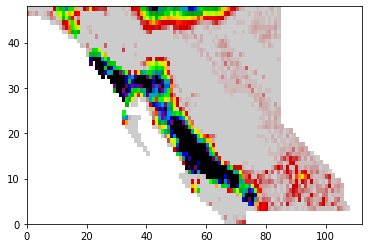

In [8]:
plt.pcolormesh(gefs_dress[0, 0, ...], vmin=0, vmax=2, cmap=plt.cm.nipy_spectral_r)

In [11]:
from tensorflow import keras
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

In [12]:
input_tensor = Input((None, None, 3))
filter_num_down = [80, 160, 320, 640]
filter_num_skip = [80, 80, 80,]
filter_num_aggregate = 320
filter_num_sup = 80
stack_num_down = 2
stack_num_up = 1
activation = 'GELU'
batch_norm = True
pool = False
unpool = False
name = 'denoise'

In [13]:
import DL_lib as DL

In [14]:
X_decoder = DL.denoise_base(input_tensor, filter_num_down, filter_num_skip, filter_num_aggregate, 
                            stack_num_down=stack_num_down, stack_num_up=stack_num_up, activation=activation, 
                            batch_norm=batch_norm, pool=pool, unpool=unpool, name=name)

OUT_stack = DL.denoise_sup_head(X_decoder, filter_num_sup, activation=activation, 
                                batch_norm=batch_norm, pool=pool, unpool=unpool, name=name)

model = Model([input_tensor,], OUT_stack)

In [15]:
model_path = '/glade/work/ksha/AnEn_UNET3M_RAW_tune.hdf'
W = DL.dummy_loader(model_path)

model.set_weights(W)


Import model:
/glade/work/ksha/AnEn_UNET3M_RAW_tune.hdf


In [16]:
#model.summary()

In [17]:
with h5py.File(save_dir+'BC_domain_info.hdf', 'r') as h5io:
    etopo_025 = h5io['etopo_bc'][...]
    land_mask_bc = h5io['land_mask_bc'][...]
grid_shape = land_mask_bc.shape

# elevation preprocess
etopo_025[etopo_025<0] = 0
max_ = np.nanmax(etopo_025)
min_ = np.nanmin(etopo_025)
etopo_025 = (etopo_025-min_)/(max_-min_)

In [18]:
BACKUP_dir = '/glade/scratch/ksha/BACKUP/'
ERA_dir = BACKUP_dir + 'ERA5/ERA5_PCT/'
bc_inds = [73, 121, 36, 148]

In [19]:
# clim
with h5py.File(ERA_dir+'PT_3hour_clim.hdf', 'r') as h5io:
    era_3h_clim = h5io['era_3h_clim'][..., bc_inds[0]:bc_inds[1], bc_inds[2]:bc_inds[3]]

# precip preprocess
era_3h_clim = np.log(era_3h_clim+1)
era_3h_clim[..., land_mask_bc] = 0.0

In [21]:
mon_ind = dt_utc_now.month-1
temp_clim = era_3h_clim[mon_ind, ...]

In [22]:
temp_clim.shape

(48, 112)

In [23]:
etopo_025.shape

(48, 112)

In [24]:
temp_precip = np.copy(gefs_dress)
temp_precip[temp_precip<0] = 0
temp_precip = np.log(temp_precip+1)

In [25]:
CNN_output = np.empty(temp_precip.shape)

In [26]:
N_seq = temp_precip.shape[0]
N_leads = temp_precip.shape[1]

In [27]:
single_seq = np.empty((N_seq, 48, 112, 3))

In [28]:
start_time = time.time()
for lead in range(N_leads):
    single_seq[..., 0] = temp_precip[:, lead, ...]
    single_seq[..., 1] = temp_clim[None, ...]
    single_seq[..., 2] = etopo_025[None, ...]
    
    single_out = model.predict([single_seq,])
    single_out = single_out[-1][..., 0]
    single_out = np.exp(single_out)-1
    
    CNN_output[:, lead, ...] = single_out
    
print('\t ... done. {} sec'.format((time.time() - start_time)))

	 ... done. 338.7806086540222 sec


In [8]:
name_output = filename_CNN_output_namelist.format(dt_fmt_string)

In [11]:
with h5py.File(output_dir+name_output, 'r') as h5io:
    CNN_output = h5io['gefs_apcp'][...]

In [13]:
CNN_output.shape

(75, 54, 48, 112)

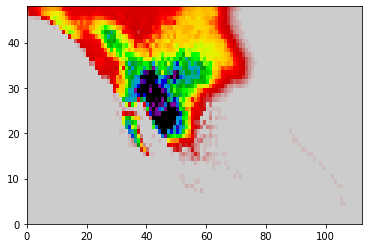

In [30]:
plt.pcolormesh(CNN_output[-15, -1, ...], vmin=0, vmax=5, cmap=plt.cm.nipy_spectral_r)

In [30]:
CNN_output.shape

(75, 54, 48, 112)